# Eurozone and NL Participation,  Unemployment,  Job Vacancy, and Vacancies per Unemployed Rates
In this notebook I look at:
* The total population of the Eurozone and the Netherlands that works or is capable of working. It's referred to as the _Population Level_. In simpler words, it's the set of people who could in theory work. Given the different approaches in different Euro area countries, one can define it using different age groups, e.g. people aged from 15 to 74, or narrower as people aged from 20 to 64.
* Another key concept in this notebook is the _Labor Force Level_ &mdash; it is a subset of the population level comprising only those who work or actively look for work. Naturally `Labor Force Level` < `Population Level`
* Finally we arrive at the _Employment Level_ &mdash; it is a subset of the labor force level comprising only those who work. It follows that: `Employment Level` < `Labor Force Level` < `Population Level`.

I then look at the different ratios involving the sizes of the above-mentioned sets:
1. **Participation Rate**: The percentage of the population level comprising those who work or are actively looking for work, i.e. $\frac{\left|\text{Labor Force Level}\right|}{\left|\text{Population Level}\right|}$
2. **Unemployment Rate**: The percentage of the labor force level comprising those who are actively looking for work, i.e. $\frac{\left|\text{Labor Force Level}\right| - \left|\text{Employment Level}\right|}{\left|\text{Labor Force Level}\right|}$
3. **Job Vacancy Rate** (aka _Unfilled Vacancies/Labor Force Ratio_): The number of unfilled vacancies as percentage of the labor force level, i.e. $\frac{\left|\text{Unfilled vacancies}\right|}{\left|\text{Labor Force Level}\right|}$
4. **Vacancies per Unemployed Rate** (aka _Unfilled Vacancies/Labor Force Ratio_): The number of unfilled vacancies as percentage of the labor force level, i.e. $\frac{\left|\text{Unfilled vacancies}\right|}{\left|\text{Unemployment Level}\right|}$
    
    ($\left|X\right|$ denotes the size of set X)

and how they've evolved since 2000.


I also construct a [Beveridge Curve](https://en.wikipedia.org/wiki/Beveridge_curve) for the NL job market by plotting the unemployment rate against the vacancy rate.

Throughout this notebook all non-percentage numbers are in the thousands of persons. I also consistently use seasonally and calendar unadjusted data given that Eurostat doesn't deliver all labour market data with a season  adjustment (e.g. the total population level). 

In [1]:
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import date

import eurostat

In [2]:
report_start = date.fromisoformat('2000-01-01')
report_end = date.today()

In [3]:
NL_PFX = 'NL '
EA_PFX = 'Euro area '
POPULATION = 'Population'
LABOUR_FORCE = 'Labour Force'
UNEMPLOYMENT_LEVEL = 'Unemployment Level'
UNFILLED_VAC = 'Unfilled Vacancies'
MEAN_LEVEL_OF = 'Mean level of '
PARTICIPATION_RATE = 'Participation Rate'
MEAN_PARTICIPATION_RATE = MEAN_LEVEL_OF + PARTICIPATION_RATE
EMPLOYMENT_POPULATION_RATE = 'Employment Rate'
MEAN_EMPLOYMENT_POPULATION_RATE = MEAN_LEVEL_OF + EMPLOYMENT_POPULATION_RATE
UNEMPLOYMENT_RATE = 'Unemployment Rate'
MEAN_UNEMPLOYMENT_RATE = MEAN_LEVEL_OF + UNEMPLOYMENT_RATE
UNFILLED_VACANCIES_POPULATION_RATE = 'Unfilled Vacancies/Population Rate'
MEAN_UNFILLED_VACANCIES_POPULATION_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_POPULATION_RATE
UNFILLED_VACANCIES_LABOR_FORCE_RATE = 'Job-vacancy Rate'
MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_LABOR_FORCE_RATE
UNEMPLOYMENT_RATIO_GRAPH_TITLE = 'Unemployment Rate'
JOB_VAC_RATE_GRAPH_TITLE = 'Job-vacancy rate (Unfilled Vacancies/Labor Force)'
JOB_VAC_PER_UNEMPLOYED = 'Job Vacancies per Unemployed'
JOB_VAC_PER_UNEMPLOYED_GRAPH_TITLE = JOB_VAC_PER_UNEMPLOYED + ' Person'
MEAN_VACANCIES_PER_UNEMPLOYED = 'Mean level of job vacancies per unemployed person'

#### Population and Labour Force Levels
Eurostat collects statistics on labour force in the EU using different age brackets. Depending on which definition you choose, you get a different definition of the labour force. E.g. choosing the bracket `Y20-64` defines the labour force as people aged 20 to 64 that work or actively search for work. Similar for unemployment rates. Switching to `Y15-74` makes the labour force larger.

Please adjust the constant `AGE_GROUP` in the cell below as you find appropriate. To be consistent with [the CBS](https://www.cbs.nl), I use the `Y15-74` age group for the Netherlands for determining the population and labour force levels.

I use the following dataseries provided by [the Eurostat](https://ec.europa.eu/eurostat):

* [lfsq_pganws](https://ec.europa.eu/eurostat/databrowser/view/lfsq_pganws/default/table?lang=en&category=labour.employ.lfsq.lfsq_pop) &mdash; Population by sex, age, citizenship and labour status (1 000).

In [4]:
#AGE_GROUP = 'Y20-64'
AGE_GROUP = 'Y15-74'

In [5]:
# Retrieving labour fource in thousands of persons. Labour force are people aged 20 to 64 that work
# or actively search for work. For the Netherlands an age bracket of 18 to 67 would be better. However
# Eurostat doesn't provide it. It does provide alterate age brackets such as Y15-74.
ea_nl_labour_force = eurostat.get_data_df('lfsq_pganws',
               filter_pars={'startPeriod': report_start, 'unit': 'THS_PER', 'sex': 'T', 'age': AGE_GROUP,
                            'citizen': 'TOTAL', 'wstatus': ['POP', 'ACT'],
                            'geo': ['EA20', 'NL']}).iloc[:, 5:]
ea_nl_labour_force = ea_nl_labour_force.set_index([ea_nl_labour_force.columns[0], ea_nl_labour_force.columns[1]]).T
ea_nl_labour_force = ea_nl_labour_force.set_axis(pd.DatetimeIndex(ea_nl_labour_force.index, 'QS'))
ea_nl_labour_force = ea_nl_labour_force.loc[ea_nl_labour_force.first_valid_index():]
ea_nl_labour_force.columns.names = 2*[None]

#### Unemployment Level
I use the following dataseries provided by [the Eurostat](https://ec.europa.eu/eurostat):

* [une_rt_q](https://ec.europa.eu/eurostat/databrowser/view/une_rt_q/default/table?lang=en&category=labour.employ.lfsi.une) &mdash; Unemployment by sex and age.

In [6]:
# Retrieving the number of unemployed in thousands of persons. Using unadjusted data for consistency's sake with
# population and labour force numbers.
ea_nl_unemployed = eurostat.get_data_df('une_rt_q',
               filter_pars={'startPeriod': report_start, 'unit': 'THS_PER', 'sex': 'T', 'age': AGE_GROUP,
                            's_adj': 'NSA', 'geo': ['EA20', 'NL']}).iloc[:, 5:]

ea_nl_unemployed = ea_nl_unemployed.set_index(ea_nl_unemployed.columns[0]).T
ea_nl_unemployed = ea_nl_unemployed.set_axis(pd.DatetimeIndex(ea_nl_unemployed.index, 'QS'))
ea_nl_unemployed = ea_nl_unemployed.loc[ea_nl_unemployed.iloc[:,1].first_valid_index():]
ea_nl_unemployed.columns.names = [None]

#### Unfilled Vacancies Level
I use the following dataseries provided by [the Eurostat](https://ec.europa.eu/eurostat):

* [jvs_q_nace2](https://ec.europa.eu/eurostat/databrowser/view/jvs_q_nace2/default/table?lang=en&category=labour.jvs) &mdash; Job vacancy statistics by NACE Rev. 2 activity - quarterly data (from 2001 onwards).

In [7]:
# Retrieving the number of vacancies and converting into thousands of persons. Using unadjusted data for consistency's sake with
# population and labour force numbers.
ea_nl_vacancies = eurostat.get_data_df('jvs_q_nace2',
               filter_pars={'startPeriod': report_start, 'nace_r2': 'A-S', 'sizeclas': 'TOTAL',
                            's_adj': 'NSA', 'indic_em': 'JOBVAC', 'geo': ['EA20', 'NL']}).iloc[:, 5:]
ea_nl_vacancies = ea_nl_vacancies.set_index(ea_nl_vacancies.columns[0]).T
ea_nl_vacancies = ea_nl_vacancies.set_axis(pd.DatetimeIndex(ea_nl_vacancies.index, 'QS'))
ea_nl_vacancies = ea_nl_vacancies.loc[ea_nl_vacancies.iloc[:,0].first_valid_index():]
ea_nl_vacancies.columns.names = [None]
ea_nl_vacancies /= 1e3

#### Aggregating datasets

In [8]:
ea_labour_mkt = pd.concat([ea_nl_labour_force.loc[:, (ea_nl_labour_force.columns.get_level_values(0), 'EA20')],
                           ea_nl_unemployed.loc[:,'EA20']], axis=1)
ea_labour_mkt.columns = [POPULATION, LABOUR_FORCE, UNEMPLOYMENT_LEVEL]
ea_labour_mkt.dropna(inplace=True)

In [9]:
ea_labour_mkt[PARTICIPATION_RATE] = ea_labour_mkt[LABOUR_FORCE] / ea_labour_mkt[POPULATION]
ea_labour_mkt[UNEMPLOYMENT_RATE] = ea_labour_mkt[UNEMPLOYMENT_LEVEL] / ea_labour_mkt[LABOUR_FORCE]

In [10]:
ea_labour_mkt

,Population,Labour Force,Unemployment Level,Participation Rate,Unemployment Rate
2009-01-01,255044.5,160064.5,15239.0,0.627594,0.095205
2009-04-01,255097.1,160537.5,15300.0,0.629319,0.095305
2009-07-01,254909.3,160287.7,15351.0,0.628803,0.095772
2009-10-01,255161.2,160840.9,16225.0,0.630350,0.100876
2010-01-01,253598.4,159443.3,17150.0,0.628724,0.107562
...,...,...,...,...,...
2023-01-01,259519.0,168865.1,11649.0,0.650685,0.068984
2023-04-01,259677.9,170012.7,10804.0,0.654706,0.063548
2023-07-01,259876.3,170717.0,11085.0,0.656916,0.064932
2023-10-01,260250.1,171011.8,11148.0,0.657106,0.065188


In [11]:
nl_labour_mkt = pd.concat([ea_nl_labour_force.loc[:, (ea_nl_labour_force.columns.get_level_values(0), 'NL')],
                           ea_nl_unemployed.loc[:,'NL'], ea_nl_vacancies.loc[:,'NL']], axis=1)
nl_labour_mkt.columns = [POPULATION, LABOUR_FORCE, UNEMPLOYMENT_LEVEL, UNFILLED_VAC]
#nl_labour_mkt.dropna(inplace=True)

In [12]:
nl_labour_mkt[PARTICIPATION_RATE] = nl_labour_mkt[LABOUR_FORCE] / nl_labour_mkt[POPULATION]
nl_labour_mkt[UNEMPLOYMENT_RATE] = nl_labour_mkt[UNEMPLOYMENT_LEVEL] / nl_labour_mkt[LABOUR_FORCE]
nl_labour_mkt[UNFILLED_VACANCIES_LABOR_FORCE_RATE] = nl_labour_mkt[UNFILLED_VAC] / nl_labour_mkt[LABOUR_FORCE]
nl_labour_mkt[JOB_VAC_PER_UNEMPLOYED] = nl_labour_mkt[UNFILLED_VAC] / nl_labour_mkt[UNEMPLOYMENT_LEVEL]

In [13]:
nl_labour_mkt

,Population,Labour Force,Unemployment Level,Unfilled Vacancies,Participation Rate,Unemployment Rate,Job-vacancy Rate,Job Vacancies per Unemployed
2000-01-01,11892.7,7982.9,NaN,NaN,0.671244,NaN,NaN,NaN
2000-04-01,11888.3,8074.2,NaN,NaN,0.679172,NaN,NaN,NaN
2000-07-01,11901.8,8154.1,NaN,NaN,0.685115,NaN,NaN,NaN
2000-10-01,11914.7,8202.5,NaN,NaN,0.688435,NaN,NaN,NaN
2001-01-01,11961.0,8201.4,NaN,216.8,0.685678,NaN,0.026435,NaN
...,...,...,...,...,...,...,...,...
2023-01-01,13306.7,10039.4,371.0,432.9,0.754462,0.036954,0.043120,1.166846
2023-04-01,13310.2,10079.0,348.0,441.2,0.757239,0.034527,0.043774,1.267816
2023-07-01,13317.3,10118.5,366.0,416.8,0.759801,0.036171,0.041192,1.138798
2023-10-01,13368.3,10145.2,349.0,389.2,0.758900,0.034401,0.038363,1.115186


### Euro area
#### Participation rate
Participation rate &mdash; is percentage of population who work or are looking for work. Where by population we take residents who are aged from 15 to 74 and who can in theory work.

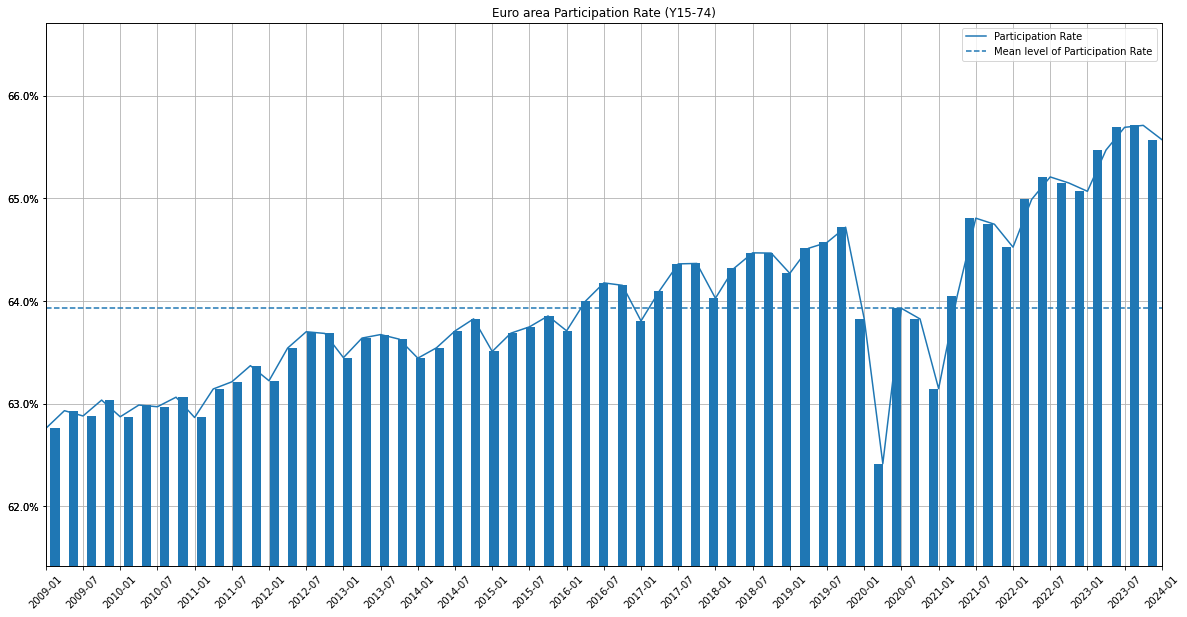

In [14]:
ax = ea_labour_mkt[PARTICIPATION_RATE].plot(figsize=(20,10), grid=True,
                                            title=EA_PFX + PARTICIPATION_RATE + f' ({AGE_GROUP})',
                                            xticks=ea_labour_mkt.index[::2], xlabel='', rot=45)
ax2 = ax.twiny()
min_pr, max_pr = ea_labour_mkt[PARTICIPATION_RATE].min() - .01, ea_labour_mkt[PARTICIPATION_RATE].max() + .01
ea_labour_mkt[PARTICIPATION_RATE].plot.bar(ax=ax2, xlabel='', ylim=(min_pr, max_pr), legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=ea_labour_mkt[PARTICIPATION_RATE].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ea_labour_mkt.index[::2])))

#### Unemployment rate

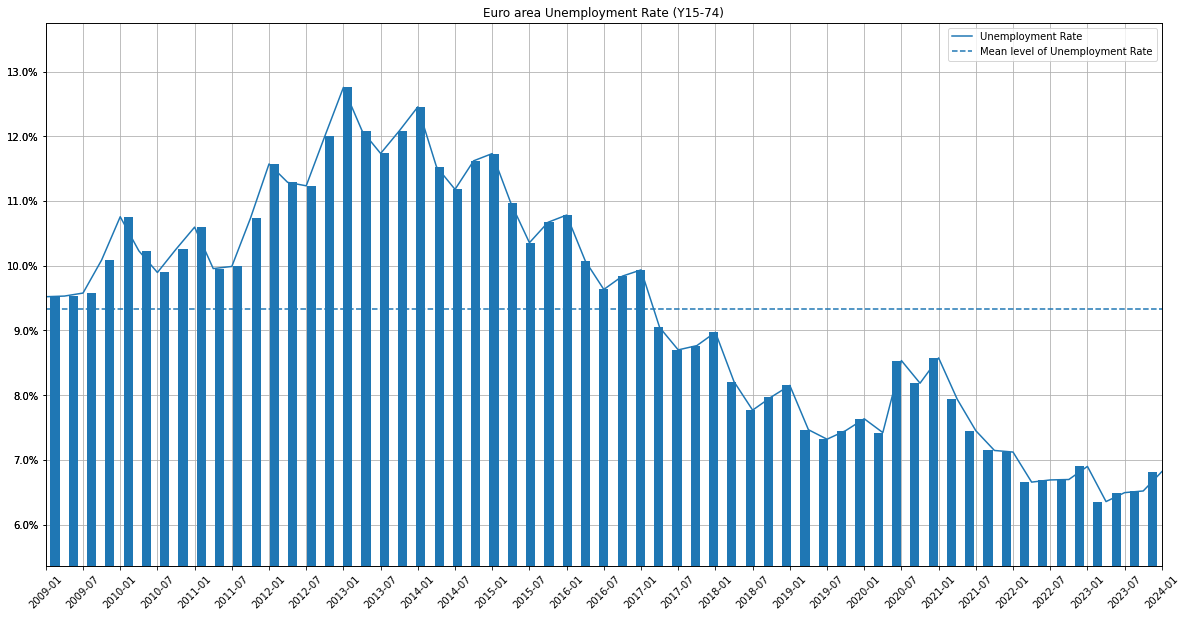

In [15]:
unempl_rate = ea_labour_mkt[UNEMPLOYMENT_RATE].dropna()
ax = unempl_rate.plot(figsize=(20,10), grid=True, xticks=unempl_rate.index[::2], xlabel='',
                      rot=45, title=EA_PFX + UNEMPLOYMENT_RATIO_GRAPH_TITLE + f' ({AGE_GROUP})')
ax2 = ax.twiny()
min_ur, max_ur = unempl_rate.min() - .01, unempl_rate.max() + .01
unempl_rate.plot.bar(ax=ax2, xlabel='', legend=False, ylim=(min_ur, max_ur))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=unempl_rate.mean(), ls='--', label=MEAN_UNEMPLOYMENT_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, unempl_rate.index[::2])))

### The Netherlands
#### Participation Rate
[Het CBS](https://www.cbs.nl/en-gb/) distinguishes between netto and brutto participation rates. Netto participation rate is the ration of the number of people who work to the total number of people in the labour force. Brutto participation rate is the ration of the number of people who work or are looking for work to the total number of people in the labour force. Netto participation rate is therefore always smaller than the brutto participation rate. In this notebook I look exclusively at the brutto participation rate as it's more representative of the job market and is the most frequently used in literature.

As I've mentioned in the beginning of this notebook, I use not seasonally adjusted data.

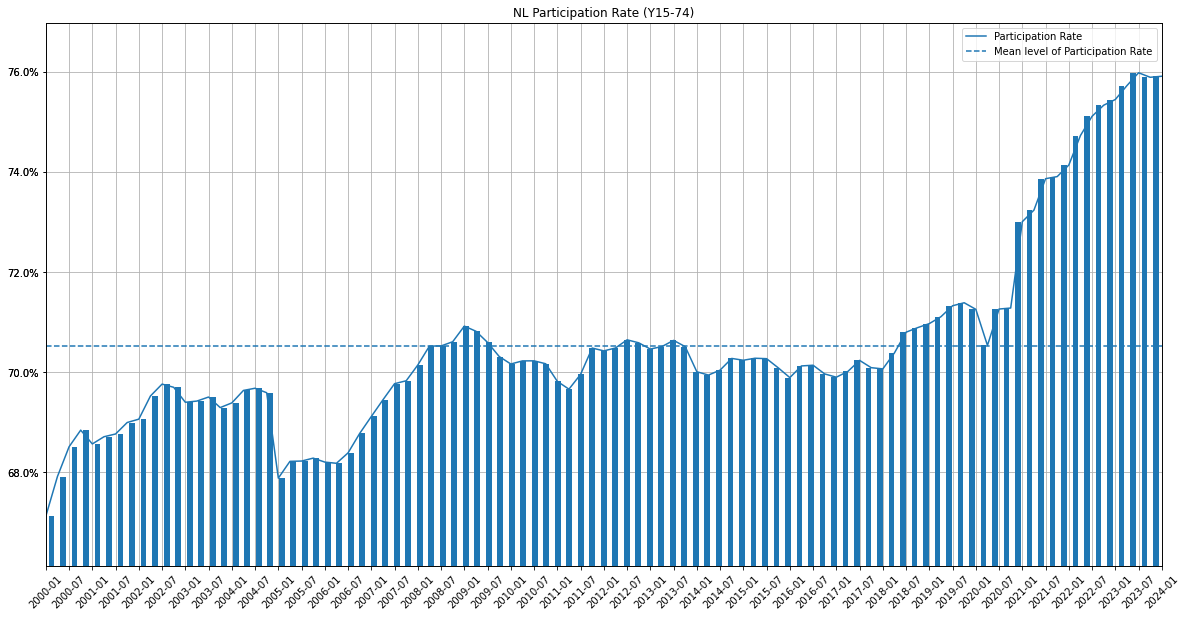

In [16]:
ax = nl_labour_mkt[PARTICIPATION_RATE].plot(figsize=(20,10), grid=True,
                                            title=NL_PFX + PARTICIPATION_RATE + f' ({AGE_GROUP})',
                                            xticks=nl_labour_mkt.index[::2], xlabel='', rot=45)
ax2 = ax.twiny()
min_pr, max_pr = nl_labour_mkt[PARTICIPATION_RATE].min() - .01, nl_labour_mkt[PARTICIPATION_RATE].max() + .01
nl_labour_mkt[PARTICIPATION_RATE].plot.bar(ax=ax2, xlabel='', ylim=(min_pr, max_pr), legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=nl_labour_mkt[PARTICIPATION_RATE].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, nl_labour_mkt.index[::2])))

#### Unemployment rate

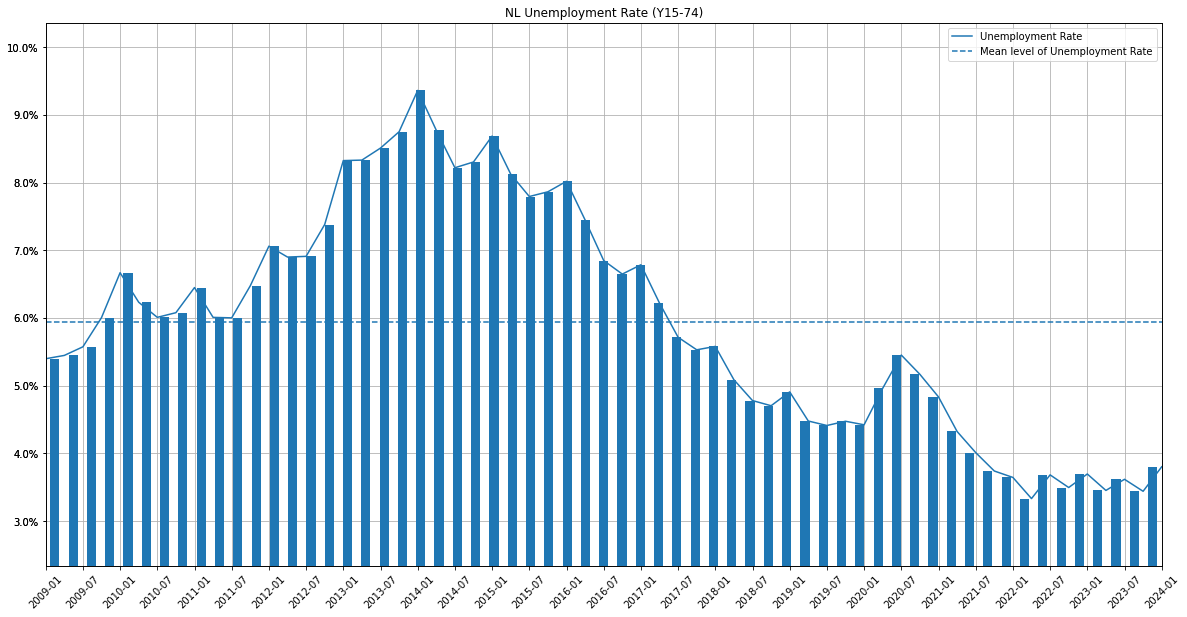

In [17]:
unempl_rate = nl_labour_mkt[UNEMPLOYMENT_RATE].dropna()
ax = unempl_rate.plot(figsize=(20,10), grid=True, xticks=unempl_rate.index[::2], xlabel='',
                      rot=45, title=NL_PFX + UNEMPLOYMENT_RATIO_GRAPH_TITLE + f' ({AGE_GROUP})')
ax2 = ax.twiny()
min_ur, max_ur = unempl_rate.min() - .01, unempl_rate.max() + .01
unempl_rate.plot.bar(ax=ax2, xlabel='', legend=False, ylim=(min_ur, max_ur))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=unempl_rate.mean(), ls='--', label=MEAN_UNEMPLOYMENT_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, unempl_rate.index[::2])))

#### Job vacancy rate
_The Job Vacancy Rate_ (aka _The Unfilled Vacancies to Labor Force rate_) is by far the most well known measure of labour market tightness. It shows the ratio of unfilled vacancies to the labour force (i.e. the total pool of people who work or are looking for work). I like this measure more than _Job vacancies per unemployed_, which I describe further down in this notebook because in the present labour market an increasing number of vacancies are filled by job switchers rather than the unemployed.

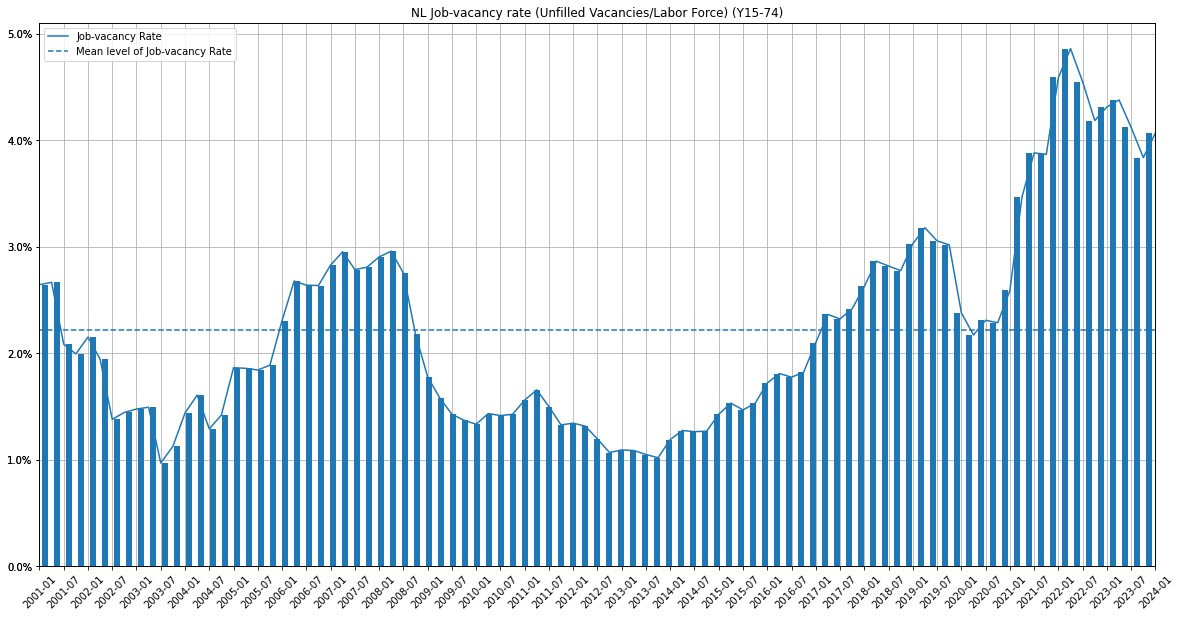

In [18]:
job_vac_rate = nl_labour_mkt[UNFILLED_VACANCIES_LABOR_FORCE_RATE].dropna()
ax = job_vac_rate.plot(figsize=(20,10), grid=True, xticks=job_vac_rate.index[::2], xlabel='', rot=45,
                       title=NL_PFX + JOB_VAC_RATE_GRAPH_TITLE + f' ({AGE_GROUP})')
ax2 = ax.twiny()
job_vac_rate.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=job_vac_rate.mean(), ls='--', label=MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, job_vac_rate.index[::2])))

#### Job vacancies per unemployed person

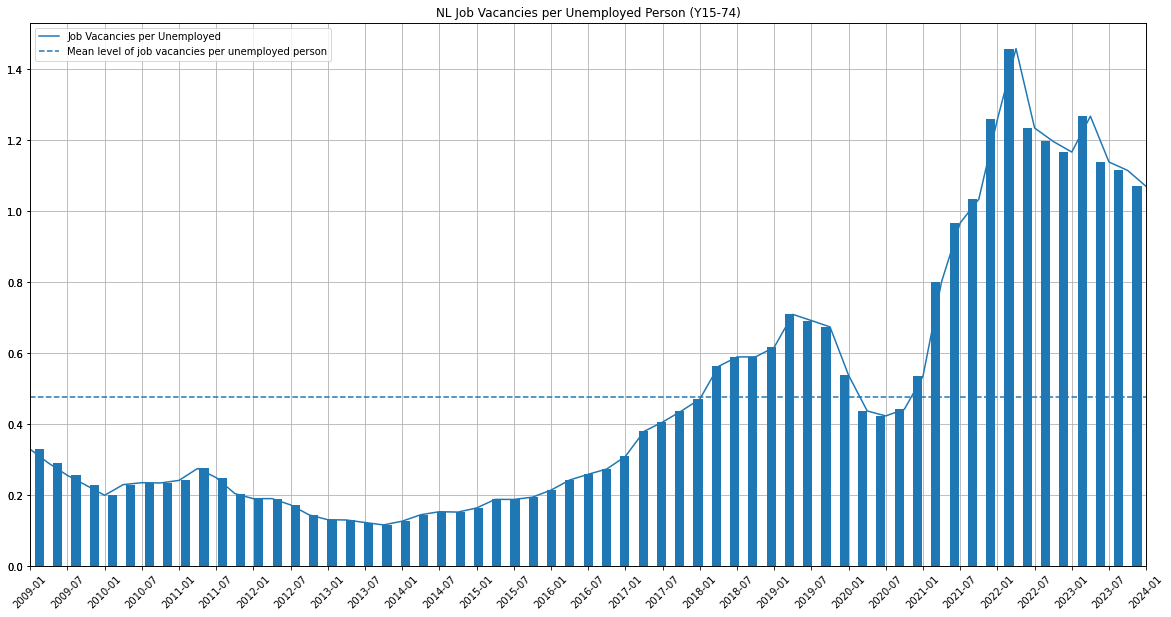

In [19]:
vac_per_unempl = nl_labour_mkt[JOB_VAC_PER_UNEMPLOYED].dropna()
ax = vac_per_unempl.plot(figsize=(20,10), grid=True, xticks=vac_per_unempl.index[::2], xlabel='', rot=45,
                         title=NL_PFX + JOB_VAC_PER_UNEMPLOYED_GRAPH_TITLE + ' ({:})'.format(AGE_GROUP))
ax2 = ax.twiny()
vac_per_unempl.plot.bar(ax=ax2, xlabel='', legend=False)
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=vac_per_unempl.mean(), ls='--', label=MEAN_VACANCIES_PER_UNEMPLOYED)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, vac_per_unempl.index[::2])))

### The Beveridge Curve
[The Beveridge Curve](https://en.wikipedia.org/wiki/Beveridge_curve) compares the unemployment rate to the job-vacancy rate (the number of job vacancies divided by the total labour force) and shows how this changes over time. I've looked at each of these rates individually earlier in this notebook, in this section I plot one against the other.

The Beveridge curve tends to show an inverse relationship — unfilled vacancies tend to increase as unemployment rate decreases. The logic being that when few are looking for a job, employers take longer to fill in their vacancies. Those years where the vacancy rate is higher for the same unemployment rate constitute less efficient a labor market where 1) skills mismatches between what employers are looking for and what job seekers have, or 2) vacancies being filled predominantly by job switchers rather than the jobless, or 3) lower willingness on the part of the unemployed to take a given job might be the reasons.

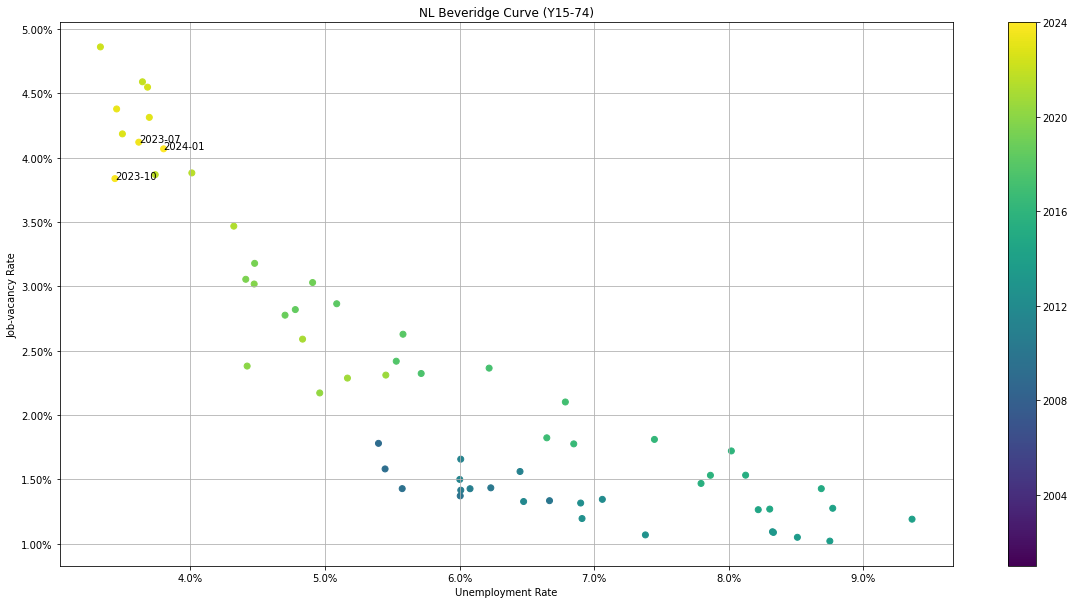

In [20]:
bvg_curve_df = nl_labour_mkt.loc[:, [UNEMPLOYMENT_RATE, UNFILLED_VACANCIES_LABOR_FORCE_RATE]]
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(x=bvg_curve_df.iloc[:,0], y=bvg_curve_df.iloc[:,1], c=mdates.date2num(bvg_curve_df.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(bvg_curve_df.columns[0])
ax.set_ylabel(bvg_curve_df.columns[1])
ax.set_title(NL_PFX + 'Beveridge Curve ({:})'.format( AGE_GROUP))
# Add labels to the last three months for ease of understanding the current trend
for i in range(-1, -4, -1):
    plt.text(bvg_curve_df.iloc[i,0], bvg_curve_df.iloc[i,1], f'{bvg_curve_df.index[i]:%Y-%m}')
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))